In [1]:
import os
import sys
import rrdtool
import pickle
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
import IPython
import IPython.display
from IPython.display import Image
from auserverdata.preparation.rrd import (
    parse_rrds_for_all_collectd_servers,
    parse_rrds_for_all_snmp_servers,
    get_time_series_data_for_collectd_servers,
    get_time_series_data_for_snmp_servers,
    get_feature_names_for_timestamp_set,
    get_feature_names_with_substring_present,
    map_feature_names_to_timestamps,
    map_timestamp_sets_to_feature_names,
    print_timestamp_set_to_feature_names_map_info
)
from auserverdata.local import get_local_config
from auserverdata.analysis import (
    plot_time_series_data_on_single_plot,
    plot_time_series_data_in_vertical_stack
)
from joblib import Parallel,delayed
import pyarrow.parquet as pq
import pyarrow.compute as pc
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

2023-11-07 22:42:58.894126: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 22:42:58.983127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 22:42:58.983151: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 22:42:58.983753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 22:42:59.035395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 22:42:59.035992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
local_config = get_local_config()

In [3]:
collectd_ts_df = get_time_series_data_for_collectd_servers(rrd_dir=local_config.rrd_dir, collectd_servers=['gpu1'])

In [4]:
timestamps_per_feature_name = map_feature_names_to_timestamps(collectd_ts_df)
feature_names_per_timestamp_set = map_timestamp_sets_to_feature_names(timestamps_per_feature_name)

In [5]:
print_timestamp_set_to_feature_names_map_info(feature_names_per_timestamp_set)

************************************************************
Info about Timestamp Set 0
    Number of timestamps: 1200
    Number of features with the these timestamps: 225
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:28
    End timestamp: 2023-05-20 04:11:18
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 1
    Number of timestamps: 1200
    Number of features with the these timestamps: 8
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2023-05-20 00:51:33
    End timestamp: 2023-05-20 04:11:23
    Total duration: 0 days 03:19:50
************************************************************
Info about Timestamp Set 2
    Number of timestamps: 1200
    Number of features with the these timestamps: 1
    Step size between timestamps: 0 days 00:00:10
    Start timestamp: 2020-07-09 14:49:41
    End timestamp: 2020-07-09 18:09:31
    Total duration: 0 d

In [6]:
feature_names = get_feature_names_for_timestamp_set(feature_names_per_timestamp_set, 0)

In [7]:
collectd_ts_df[feature_names].dropna()

server                  gpu1                                               \
component              cpu-0                                                
rrd                 cpu-idle cpu-interrupt cpu-nice cpu-softirq cpu-steal   
data_source            value         value    value       value     value   
time                                                                        
2023-05-20 00:51:28    99.70           0.0      0.0        0.00       0.0   
2023-05-20 00:51:38    99.72           0.0      0.0        0.00       0.0   
2023-05-20 00:51:48    99.78           0.0      0.0        0.00       0.0   
2023-05-20 00:51:58    99.68           0.0      0.0        0.00       0.0   
2023-05-20 00:52:08    99.62           0.0      0.0        0.00       0.0   
...                      ...           ...      ...         ...       ...   
2023-05-20 04:10:38    99.70           0.0      0.0        0.08       0.0   
2023-05-20 04:10:48    99.66           0.0      0.0        0.00       0.0   
2023-05-20 04:10:58    95.64           0.0      0.0        0.00       0.0   
2023-05-20 04:11:08    84.08           0.0      0.0        0.00       0.0   
2023-05-20 04:11:18    99.60           0.0      0.0        0.00       0.0   

server                                                                   ...  \
component                                           cpu-1                ...   
rrd                 cpu-system cpu-user cpu-wait cpu-idle cpu-interrupt  ...   
data_source              value    value    value    value         value  ...   
time                                                                     ...   
2023-05-20 00:51:28       0.02     0.02     0.12   100.00           0.0  ...   
2023-05-20 00:51:38       0.08     0.08     0.18    99.98           0.0  ...   
2023-05-20 00:51:48       0.02     0.00     0.10    99.92           0.0  ...   
2023-05-20 00:51:58       0.10     0.02     0.10   100.00           0.0  ...   
2023-05-20 00:52:08       0.10     0.08     0.12    99.98           0.0  ...   
...                        ...      ...      ...      ...           ...  ...   
2023-05-20 04:10:38       0.02     0.02     0.10    99.92           0.0  ...   
2023-05-20 04:10:48       0.10     0.08     0.10    99.96           0.0  ...   
2023-05-20 04:10:58       0.12     0.00     3.98    99.78           0.0  ...   
2023-05-20 04:11:08       0.18     0.00    15.64    99.74           0.0  ...   
2023-05-20 04:11:18       0.08     0.00     0.18    99.90           0.0  ...   

server                                                                       \
component           interface-lo      load                           memory   
rrd                   if_packets      load                  memory-buffered   
data_source                   tx shortterm midterm longterm           value   
time                                                                          
2023-05-20 00:51:28          0.0     0.174   0.398    0.470       3100672.0   
2023-05-20 00:51:38          0.0     0.146   0.388    0.468       3100672.0   
2023-05-20 00:51:48          0.0     0.126   0.376    0.460       3100672.0   
2023-05-20 00:51:58          0.0     0.106   0.358    0.458       3100672.0   
2023-05-20 00:52:08          0.0     0.088   0.348    0.450       3100672.0   
...                          ...       ...     ...      ...             ...   
2023-05-20 04:10:38          0.0     0.184   0.288    0.430       3100672.0   
2023-05-20 04:10:48          0.0     0.156   0.278    0.430       3100672.0   
2023-05-20 04:10:58          0.0     0.136   0.268    0.428       3100672.0   
2023-05-20 04:11:08          0.0     0.132   0.262    0.420       3100672.0   
2023-05-20 04:11:18          0.0     0.206   0.274    0.422       3100672.0   

server                                                            \
component                                                          
rrd                 memory-cached   memory-free memory-slab_recl   
data_source      

In [10]:
cpu_feature_names = get_feature_names_with_substring_present(feature_names,'cpu')
memory_feature_names = get_feature_names_with_substring_present(feature_names, 'memory')
feature_names = cpu_feature_names + memory_feature_names

In [11]:
memory_feature_names

[('gpu1', 'memory', 'memory-free', 'value'),
 ('gpu1', 'memory', 'memory-slab_recl', 'value'),
 ('gpu1', 'memory', 'memory-slab_unrecl', 'value'),
 ('gpu1', 'memory', 'memory-used', 'value'),
 ('gpu1', 'memory', 'memory-cached', 'value'),
 ('gpu1', 'memory', 'memory-buffered', 'value')]

### Data Preparation

The CPU features for GPU1 have timestamps 2 seconds after the CPU Temperature feature. The below sets all features to have the timestamps of the CPU Usage features. There are 1200 datapoints in the data, each separated by 10 seconds. 

In [20]:
# label_of_interest = 'temperature-CPU1 Temp processor (3.1)'
# label_df = collectd_ts_df['gpu1']['ipmi'][label_of_interest].dropna()

label_of_interest = 'memory_used'
label_df = collectd_ts_df[('gpu1', 'memory', 'memory-used', 'value')].dropna()

In [21]:
df1 = collectd_ts_df[cpu_feature_names].dropna()
df1.columns = ['/'.join(col) for col in df1.columns]
df1[label_of_interest] = label_df.values
columns_to_drop = [col for col in df1.columns if df1[col].nunique() == 1]
df1.drop(columns=columns_to_drop, inplace=True)

In [22]:
df1

,gpu1/cpu-16/cpu-idle/value,gpu1/cpu-3/cpu-user/value,gpu1/cpu-23/cpu-wait/value,gpu1/cpu-2/cpu-softirq/value,gpu1/cpu-11/cpu-user/value,gpu1/cpu-2/cpu-wait/value,gpu1/cpu-21/cpu-system/value,gpu1/cpu-23/cpu-system/value,gpu1/cpu-8/cpu-idle/value,gpu1/cpu-5/cpu-wait/value,...,gpu1/cpu-12/cpu-wait/value,gpu1/cpu-8/cpu-user/value,gpu1/cpu-5/cpu-system/value,gpu1/cpu-0/cpu-idle/value,gpu1/cpu-1/cpu-user/value,gpu1/cpu-9/cpu-idle/value,gpu1/cpu-22/cpu-softirq/value,gpu1/cpu-18/cpu-idle/value,gpu1/cpu-12/cpu-idle/value,memory_used
time,,,,,,,,,,,,,,,,,,,,,
2023-05-20 00:51:28,100.00,0.02,0.0,0.0,0.00,0.0,0.00,0.0,99.80,0.00,...,0.0,0.08,0.08,99.70,0.00,99.62,0.00,100.0,100.0,4.539599e+09
2023-05-20 00:51:38,100.00,0.08,0.0,0.0,0.00,0.0,0.06,0.0,99.76,0.00,...,0.0,0.02,0.00,99.72,0.00,99.70,0.00,100.0,100.0,4.539404e+09
2023-05-20 00:51:48,100.00,0.02,0.0,0.0,0.00,0.0,0.24,0.0,99.64,0.00,...,0.0,0.08,0.00,99.78,0.00,99.68,0.00,100.0,100.0,4.538814e+09
2023-05-20 00:51:58,99.98,0.10,0.0,0.0,0.02,0.0,0.00,0.0,99.78,0.00,...,0.0,0.02,0.00,99.68,0.00,99.64,0.00,100.0,100.0,4.538816e+09
2023-05-20 00:52:08,99.92,0.08,0.0,0.0,0.08,0.0,0.04,0.0,99.70,0.00,...,0.0,0.10,0.00,99.62,0.00,99.80,0.00,100.0,100.0,4.538332e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20 04:10:38,100.00,0.08,0.0,0.0,0.00,0.0,0.00,0.0,99.60,0.00,...,0.0,0.18,0.10,99.70,0.02,99.64,0.00,100.0,100.0,4.551388e+09
2023-05-20 04:10:48,100.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,99.54,0.00,...,0.0,0.14,0.08,99.66,0.08,99.80,0.00,100.0,100.0,4.541681e+09
2023-05-20 04:10:58,100.00,0.02,0.0,0.0,0.04,0.0,0.00,0.0,99.36,0.00,...,0.0,0.28,0.00,95.64,0.00,99.62,0.00,100.0,100.0,4.547097e+09


#### Splitting

In [24]:
n = len(df1)
train_df = df1[0:int(n*0.7)]
val_df = df1[int(n*0.7):int(n*0.9)]
test_df = df1[int(n*0.9):]

# Check for columns with the same value at every index
columns_to_drop = []
for column in train_df.columns:
    if len(train_df[column].unique()) == 1:
        columns_to_drop.append(column)

# Drop the columns with the same value at every index
train_df = train_df.drop(columns=columns_to_drop)
val_df = val_df.drop(columns=columns_to_drop)
test_df = test_df.drop(columns=columns_to_drop)

column_indices = {name: i for i, name in enumerate(train_df.columns)}
num_features = train_df.shape[1]

In [25]:
train_df.shape, val_df.shape, test_df.shape

((840, 110), (240, 110), (120, 110))

#### Scaling

In [26]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [27]:
train_df.shape, val_df.shape, test_df.shape

((840, 110), (240, 110), (120, 110))

In [28]:
train_df

,gpu1/cpu-16/cpu-idle/value,gpu1/cpu-3/cpu-user/value,gpu1/cpu-23/cpu-wait/value,gpu1/cpu-2/cpu-softirq/value,gpu1/cpu-11/cpu-user/value,gpu1/cpu-2/cpu-wait/value,gpu1/cpu-21/cpu-system/value,gpu1/cpu-23/cpu-system/value,gpu1/cpu-8/cpu-idle/value,gpu1/cpu-5/cpu-wait/value,...,gpu1/cpu-19/cpu-system/value,gpu1/cpu-12/cpu-wait/value,gpu1/cpu-8/cpu-user/value,gpu1/cpu-5/cpu-system/value,gpu1/cpu-0/cpu-idle/value,gpu1/cpu-1/cpu-user/value,gpu1/cpu-9/cpu-idle/value,gpu1/cpu-18/cpu-idle/value,gpu1/cpu-12/cpu-idle/value,memory_used
time,,,,,,,,,,,,,,,,,,,,,
2023-05-20 00:51:28,0.130187,-0.832286,-0.058997,-0.083927,-0.883614,-0.042863,-0.823074,-0.131795,0.336121,-0.103011,...,-0.304798,-0.041853,-0.154439,-0.137841,0.242057,-0.407693,0.131163,0.206257,0.213269,-0.258985
2023-05-20 00:51:38,0.130187,0.345345,-0.058997,-0.083927,-0.883614,-0.042863,-0.303888,-0.131795,0.299479,-0.103011,...,-0.304798,-0.041853,-1.081075,-0.242293,0.245289,-0.407693,0.206600,0.206257,0.213269,-0.278727
2023-05-20 00:51:48,0.130187,-0.832286,-0.058997,-0.083927,-0.883614,-0.042863,1.253668,-0.131795,0.189554,-0.103011,...,-0.263167,-0.041853,-0.154439,-0.242293,0.254984,-0.407693,0.187741,0.206257,0.213269,-0.338454
2023-05-20 00:51:58,0.116040,0.737888,-0.058997,-0.083927,-0.493989,-0.042863,-0.823074,-0.131795,0.317800,-0.103011,...,-0.096643,-0.041853,-1.081075,-0.242293,0.238825,-0.407693,0.150022,0.206257,0.213269,-0.338288
2023-05-20 00:52:08,0.073599,0.345345,-0.058997,-0.083927,0.674886,-0.042863,-0.476950,-0.131795,0.244517,-0.103011,...,-0.096643,-0.041853,0.154439,-0.242293,0.229130,-0.407693,0.300898,0.206257,0.213269,-0.387313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-20 03:10:38,0.130187,0.345345,-0.058997,-0.083927,-0.883614,-0.042863,-0.823074,-0.131795,0.336121,-0.103011,...,0.069881,-0.041853,0.154439,-0.216180,0.242057,0.824184,0.187741,-0.521319,0.207074,-0.121863
2023-05-20 03:10:48,0.130187,-0.832286,-0.058997,-0.083927,-0.883614,-0.042863,-0.823074,-0.131795,0.317800,-0.103011,...,-0.096643,-0.041853,-0.154439,-0.137841,0.242057,0.824184,0.131163,-2.357583,0.182296,-0.120951
2023-05-20 03:10:58,0.116040,0.345345,-0.058997,-0.083927,-0.493989,-0.042863,-0.823074,-0.131795,0.226196,-0.103011,...,-0.138274,-0.041853,-1.081075,-0.242293,-1.238125,0.577809,0.018006,0.090768,0.188491,-0.129495


#### Window Creation

In [29]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                            enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [30]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [48]:
def plot(self, model=None, plot_col=label_of_interest, max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(label_of_interest + '_normed')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [10 Second Intervals]')

WindowGenerator.plot = plot

In [32]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [33]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

### Helper Functions

In [34]:
def compile_and_fit(model, window, learning_rate=1e-6, epochs=50, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [35]:
def plot_train_val_loss(history):
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

## Single Step Modeling

### Window Creation

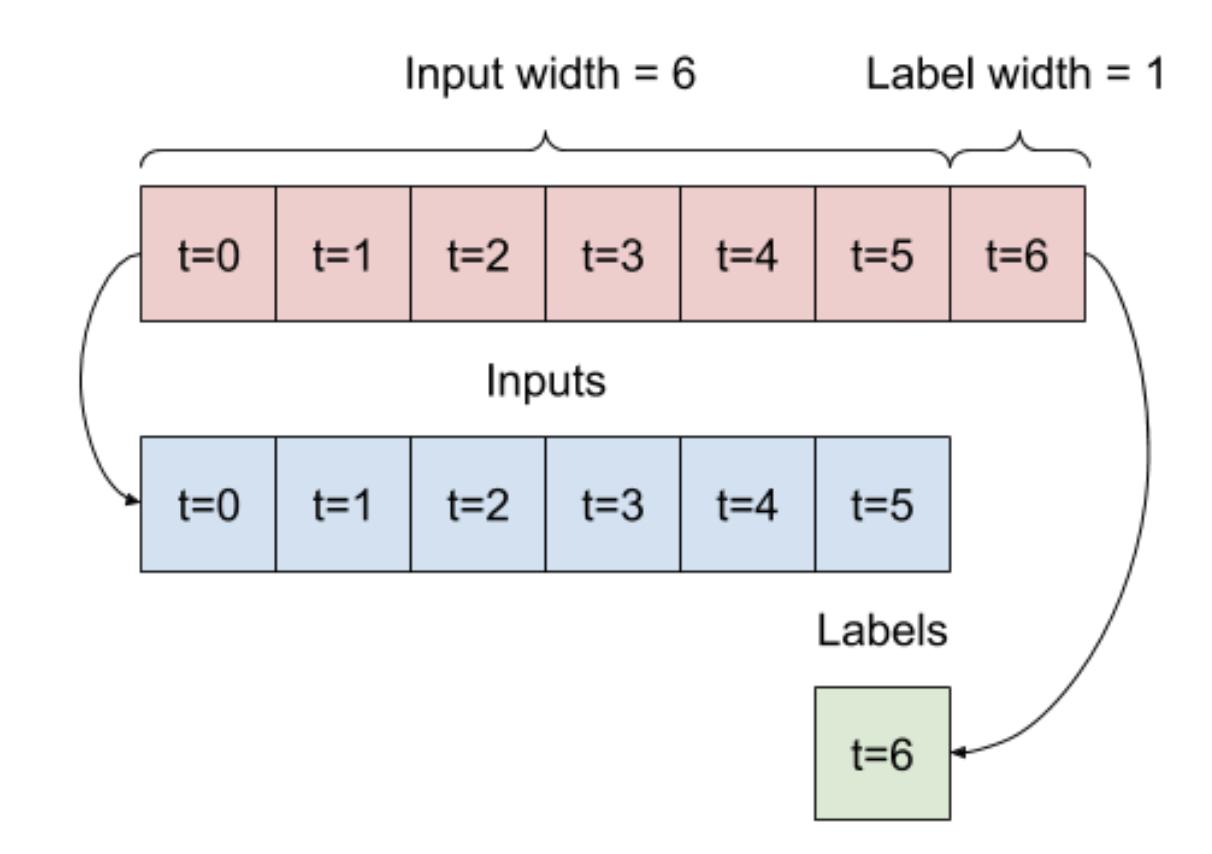

In [36]:
Image('img/window_gen_example.png', width = 300, height = 200)

In [37]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=[label_of_interest])

single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['memory_used']

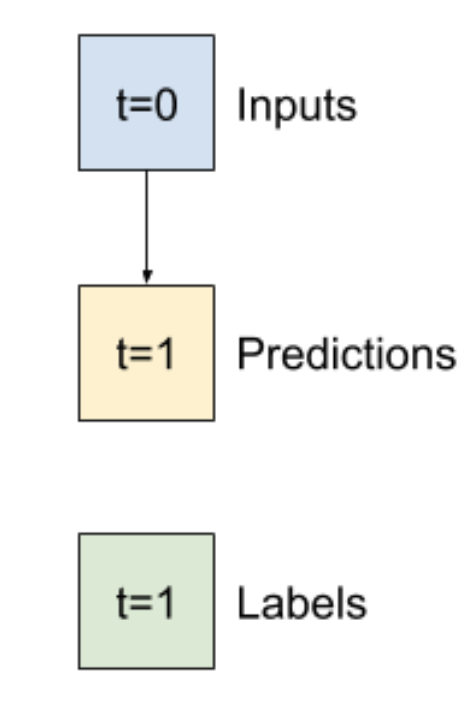

In [38]:
Image(filename='img/singlewindow.png', width = 200, height = 300)

In [39]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 110)
Labels shape (batch, time, features): (32, 1, 1)


2023-11-07 22:50:08.970218: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


A wider WindowGenerator that generates windows 24 hours of consecutive inputs and labels at a time. The new wide_window variable doesn't change the way the model operates. The model still makes predictions one hour into the future based on a single input time step. Here, the time axis acts like the batch axis: each prediction is made independently with no interaction between time steps:

In [40]:
wide_window = WindowGenerator(
    input_width=30, label_width=30, shift=1,
    label_columns=[label_of_interest])

wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['memory_used']

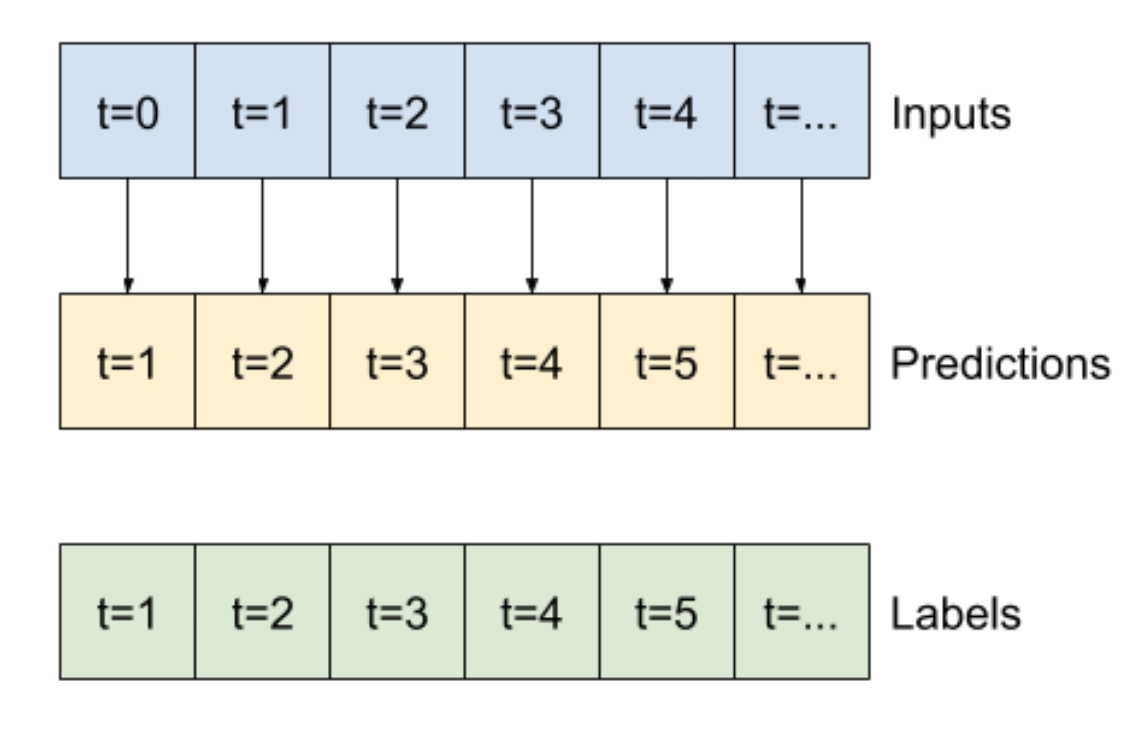

In [41]:
Image(filename='img/widewindow.png', width = 300, height = 200)

In [42]:
for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 30, 110)
Labels shape (batch, time, features): (32, 30, 1)


### Baseline Model

Start with a model that just returns the current label as the prediction, predicting "No change"

In [43]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [44]:
baseline = Baseline(label_index=column_indices[label_of_interest])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

8/8 [==============================] - 0s 729us/step - loss: 0.3758 - mean_absolute_error: 0.2729


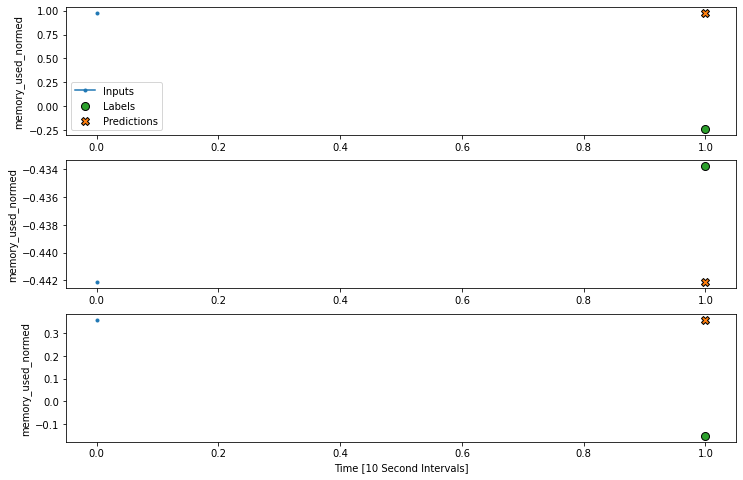

In [49]:
single_step_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 24 hours. This deserves some explanation:

- The blue Inputs line shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.
- The green Labels dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
- The orange Predictions crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the Labels.


In [50]:
baseline = Baseline(label_index=column_indices[label_of_interest])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

1/7 [===>..........................] - ETA: 0s - loss: 0.4478 - mean_absolute_error: 0.3124

7/7 [==============================] - 0s 611us/step - loss: 0.3996 - mean_absolute_error: 0.2818


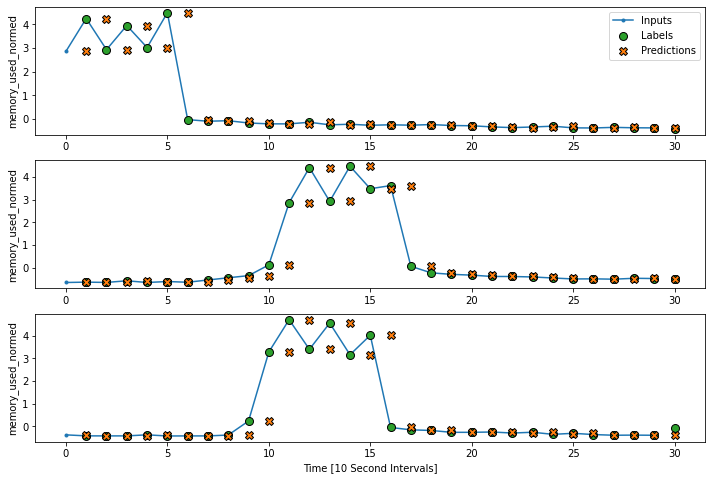

In [51]:
wide_window.plot(baseline)

### Linear Model

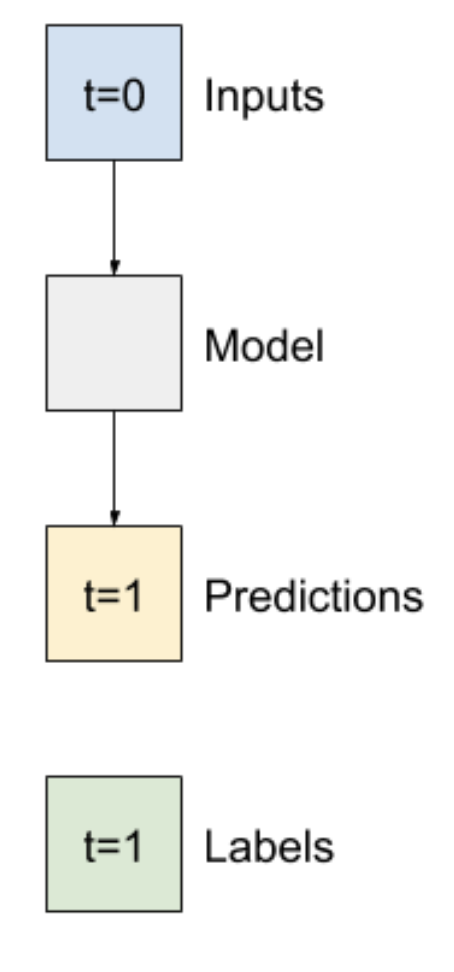

In [52]:
Image(filename='img/linear.png', width = 100, height = 200)

In [53]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [54]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 30, 110)
Output shape: (32, 30, 1)


7/7 [==============================] - 0s 577us/step - loss: 0.3327 - mean_absolute_error: 0.3223


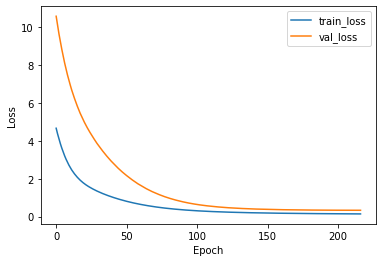

In [55]:
history = compile_and_fit(linear, wide_window, epochs = 300, learning_rate=1e-4)
IPython.display.clear_output()
val_performance['Linear'] = linear.evaluate(wide_window.val)
performance['Linear'] = linear.evaluate(wide_window.test, verbose=-1)
plot_train_val_loss(history)

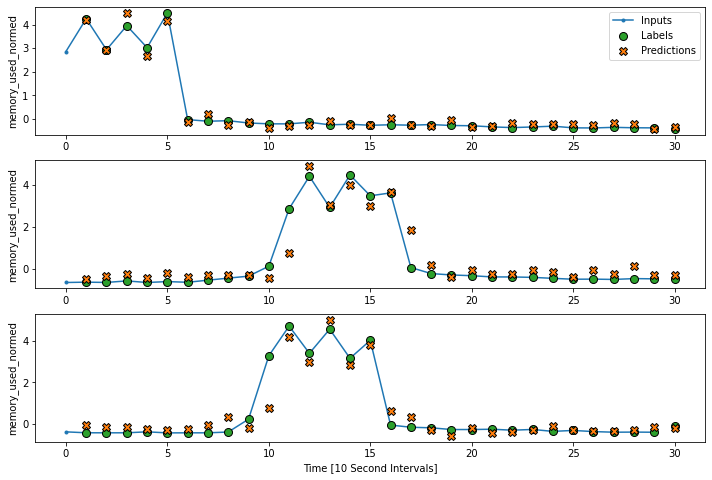

In [56]:
wide_window.plot(linear)

### Dense Model

3/3 [==============================] - 0s 1ms/step - loss: 0.2407 - mean_absolute_error: 0.3084


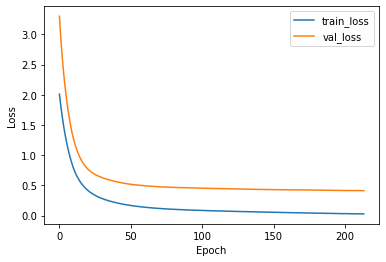

In [57]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window, epochs=1000, learning_rate=1e-5)
IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test, verbose=1)
plot_train_val_loss(history)

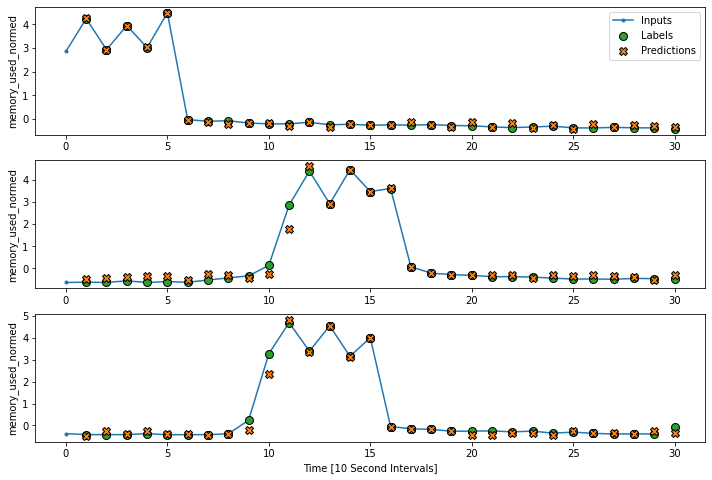

In [58]:
wide_window.plot(dense)

### Multi-Step Dense

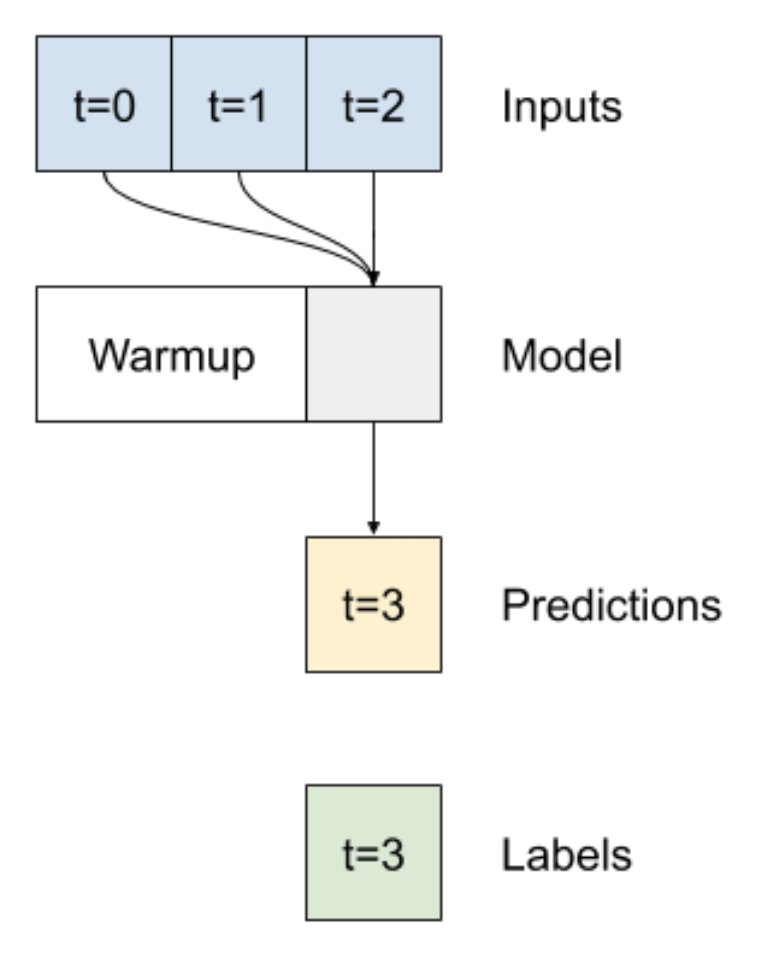

In [212]:
Image(filename='img/multistepdense.png', width = 300, height = 200)

In [59]:
CONV_WIDTH = 6
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=[label_of_interest])

conv_window

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['memory_used']

Text(0.5, 1.0, 'Given 6 timestep of inputs, predict 1 timestep into the future.')

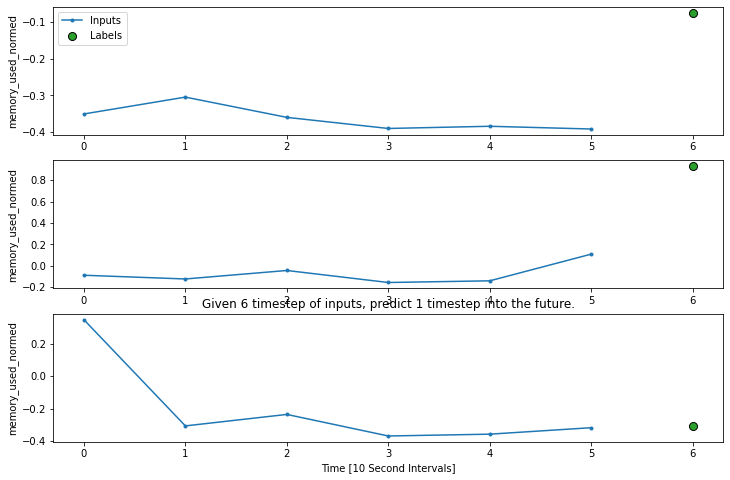

In [60]:
conv_window.plot()
plt.title("Given 6 timestep of inputs, predict 1 timestep into the future.")

In [61]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [62]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 6, 110)
Output shape: (32, 1, 1)


4/4 [==============================] - 0s 754us/step - loss: 0.3970 - mean_absolute_error: 0.4469


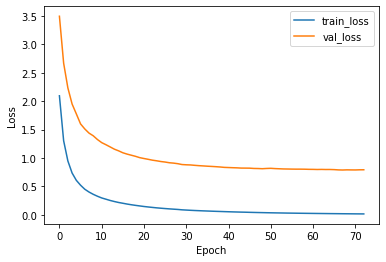

In [63]:
history = compile_and_fit(multi_step_dense, conv_window, epochs=2000, learning_rate=1e-4, patience=5)
IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=1)
plot_train_val_loss(history)

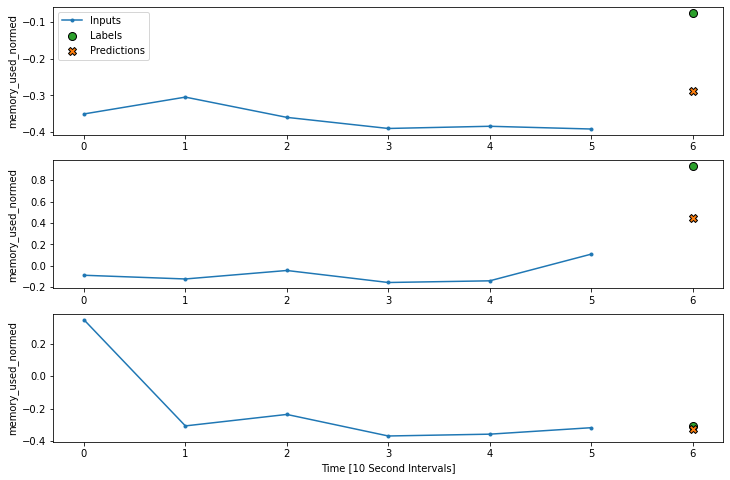

In [64]:
conv_window.plot(multi_step_dense)

### CNN

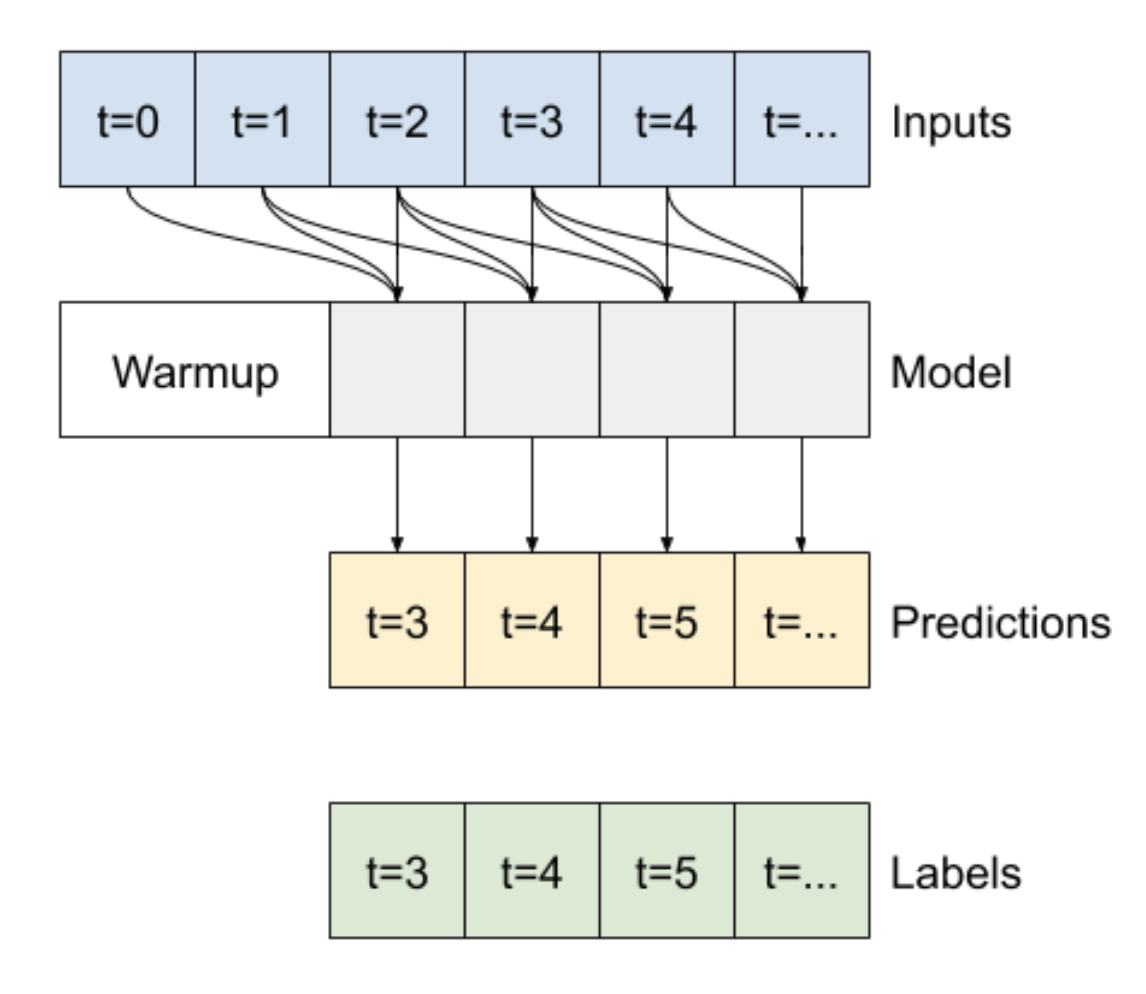

In [219]:
Image(filename='img/cnn.png', width = 300, height = 200)

In [65]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=16,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    # tf.keras.layers.Dense(units=256, activation='relu'),
    # tf.keras.layers.Dense(units=128, activation='relu'),
    # tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [66]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 6, 110)
Output shape: (32, 1, 1)


8/8 [==============================] - 0s 559us/step - loss: 0.5434 - mean_absolute_error: 0.4392


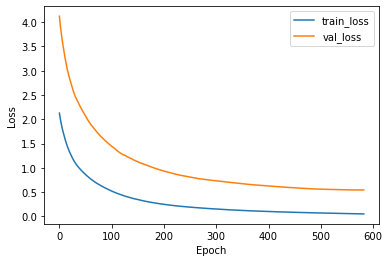

In [67]:
history = compile_and_fit(conv_model, conv_window, epochs = 1000, learning_rate=1e-5, patience=10)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
plot_train_val_loss(history)

In [68]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 30, 110)
Labels shape: (32, 30, 1)
Output shape: (32, 25, 1)


In [69]:
LABEL_WIDTH = 30
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=[label_of_interest])

wide_conv_window

Total window size: 36
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Label indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35]
Label column name(s): ['memory_used']

In [70]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 35, 110)
Labels shape: (32, 30, 1)
Output shape: (32, 30, 1)


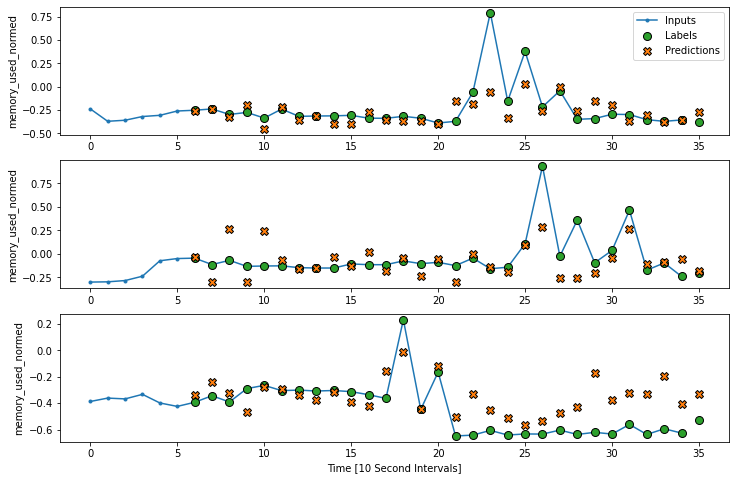

In [71]:
wide_conv_window.plot(conv_model)

### LSTM

In [77]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(units=256),
    tf.keras.layers.Dense(units=128),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Dense(units=32),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [78]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 30, 110)
Output shape: (32, 30, 1)


7/7 [==============================] - 0s 4ms/step - loss: 0.4733 - mean_absolute_error: 0.4002


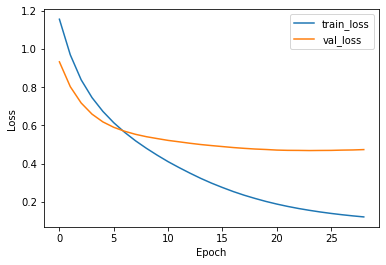

In [79]:
history = compile_and_fit(lstm_model, wide_window, epochs=1000, learning_rate=1e-5, patience=5)
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)
plot_train_val_loss(history)

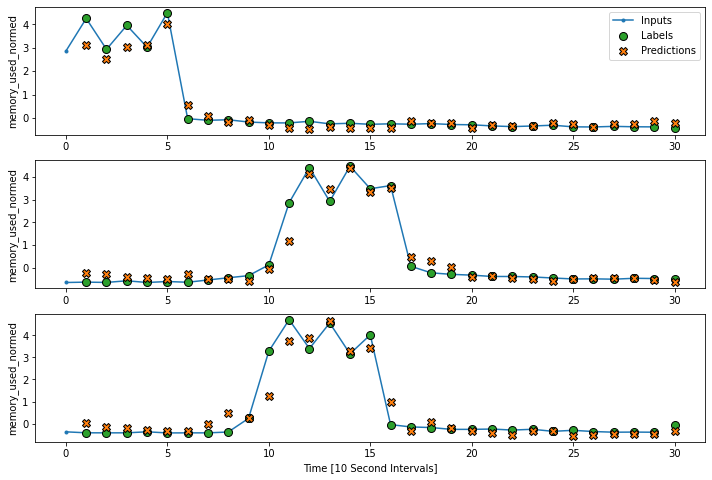

In [80]:
wide_window.plot(lstm_model)

### Model Comparison

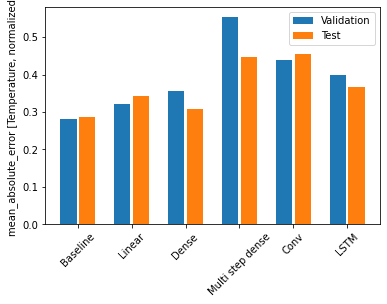

In [81]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Temperature, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

## Multi-Step Modeling

Total window size: 18
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Label indices: [12 13 14 15 16 17]
Label column name(s): None

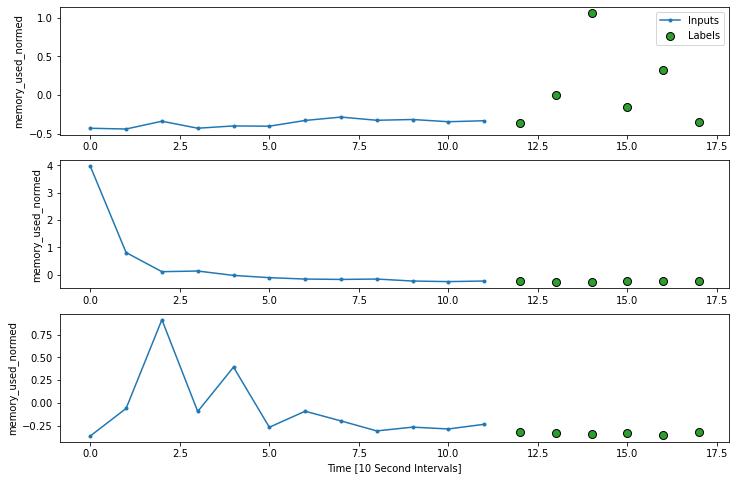

In [102]:
OUT_STEPS = 6
multi_window = WindowGenerator(input_width=12,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baselines

7/7 [==============================] - 0s 586us/step - loss: 4.8640 - mean_absolute_error: 0.4051


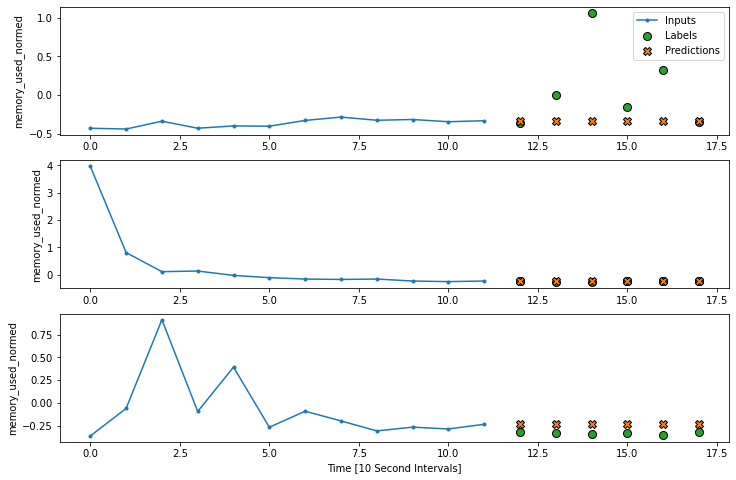

In [103]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

### Single-Shot Models

#### Linear

7/7 [==============================] - 0s 585us/step - loss: 2.6033 - mean_absolute_error: 0.3636


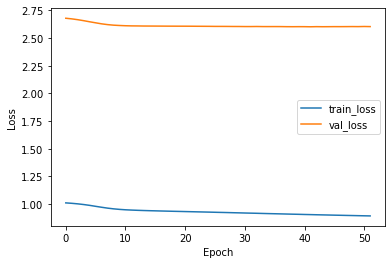

In [104]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # tf.keras.layers.Dense(512,activation='relu'),
    # tf.keras.layers.Dense(256,activation='relu'),
    # tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window, epochs=1000, learning_rate=1e-4, patience=10)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
plot_train_val_loss(history)

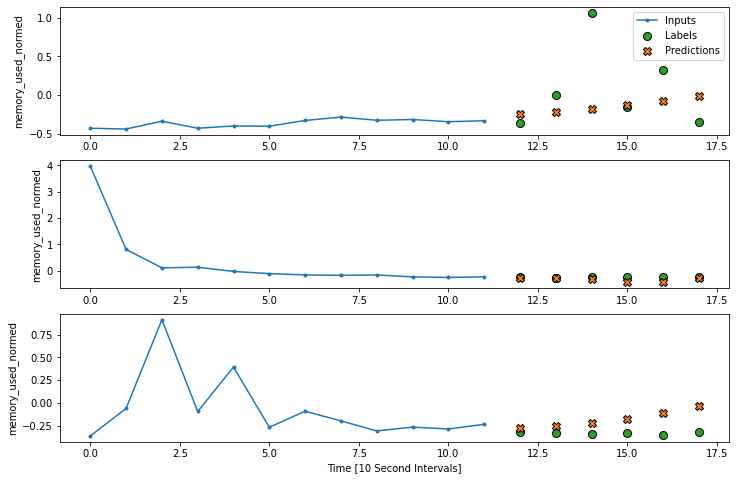

In [105]:
multi_window.plot(multi_linear_model)

#### Dense

7/7 [==============================] - 0s 770us/step - loss: 2.6627 - mean_absolute_error: 0.3751


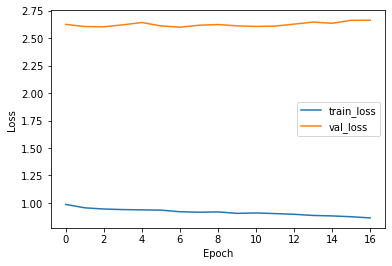

In [119]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window, epochs=1000, learning_rate=1e-3, patience=10)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
plot_train_val_loss(history)

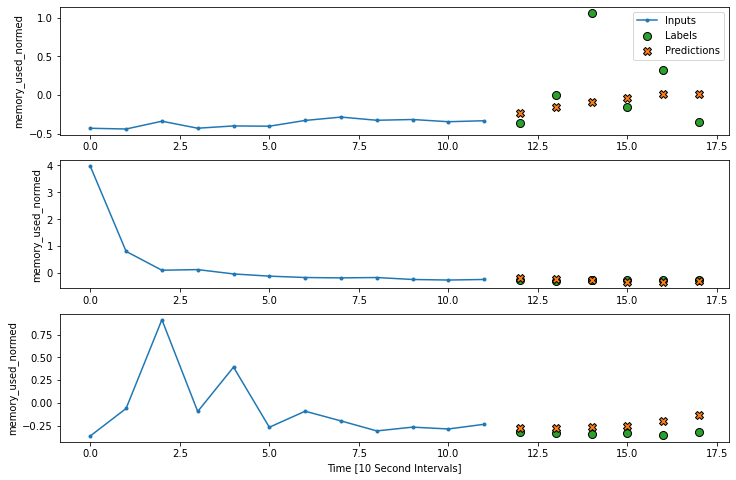

In [116]:
multi_window.plot(multi_dense_model)

#### CNN

7/7 [==============================] - 0s 1ms/step - loss: 2.5916 - mean_absolute_error: 0.4018


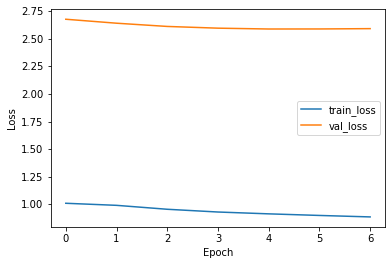

In [110]:
CONV_WIDTH = 6
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(1024, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(256,activation='relu'),
    # tf.keras.layers.Dense(128,activation='relu'),
    # tf.keras.layers.Dense(64,activation='relu'),
    # tf.keras.layers.Dense(32,activation='relu'),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window, epochs=1000, learning_rate=1e-4)

IPython.display.clear_output()
multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
plot_train_val_loss(history)


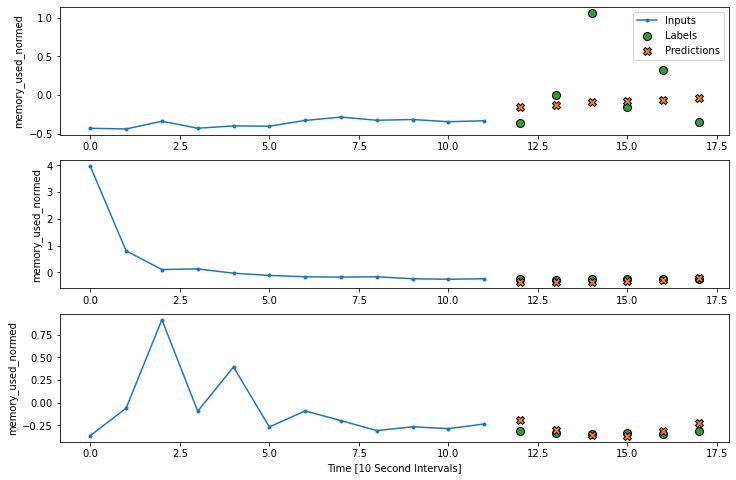

In [111]:
multi_window.plot(multi_conv_model)

#### LSTM/RNN

7/7 [==============================] - 0s 1ms/step - loss: 2.6549 - mean_absolute_error: 0.4398


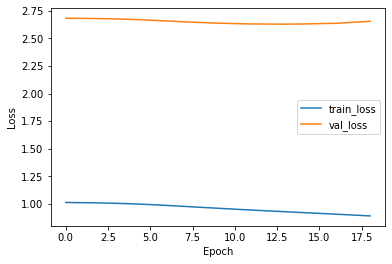

In [112]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(256,activation='relu'),
    # tf.keras.layers.Dense(128,activation='relu'),
    # tf.keras.layers.Dense(64,activation='relu'),
    # tf.keras.layers.Dense(32,activation='relu'),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window, epochs=1000, learning_rate=1e-4, patience=5)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
plot_train_val_loss(history)

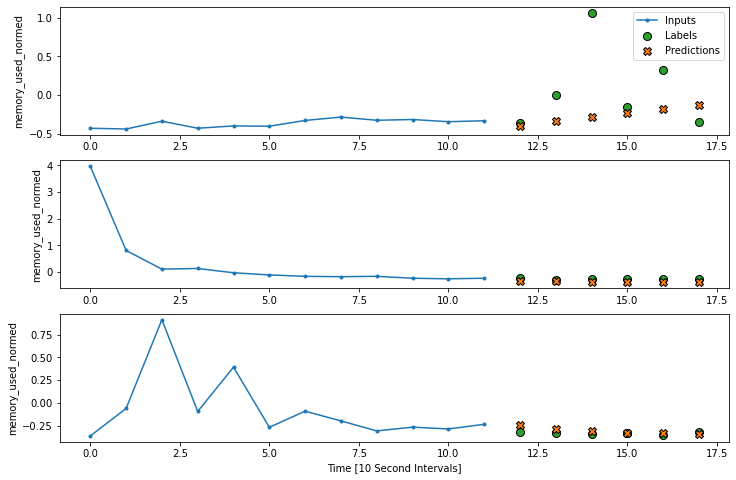

In [113]:
multi_window.plot(multi_lstm_model)

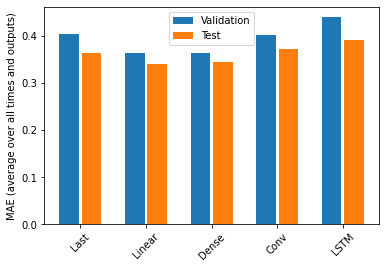

In [114]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Autoregressive Models

In [94]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [95]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [96]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [97]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 110])

In [98]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [99]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 6, 110)


8/8 [==============================] - 0s 924us/step - loss: 2.6159 - mean_absolute_error: 0.4141


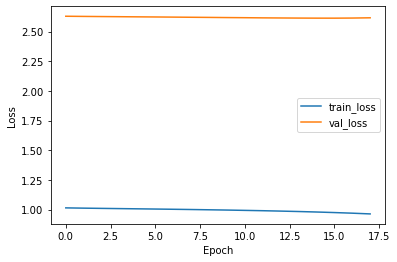

In [100]:
history = compile_and_fit(feedback_model, multi_window, epochs=1000, learning_rate=1e-4)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
plot_train_val_loss(history)

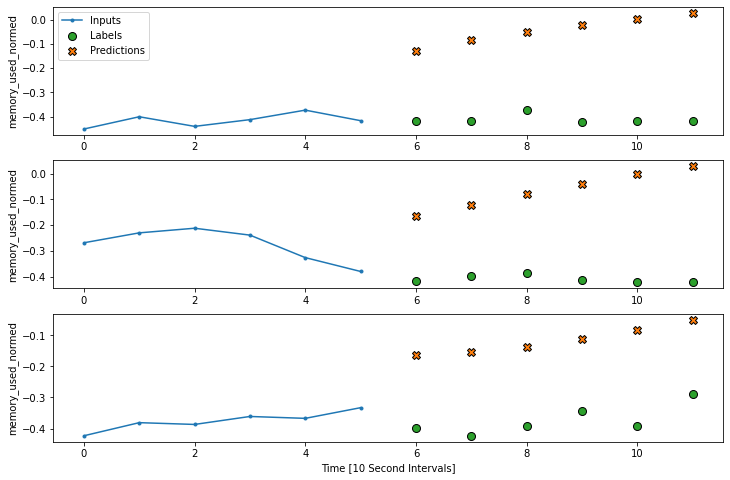

In [101]:
multi_window.plot(feedback_model)